In [1]:
# limit the thread used by numpy 
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"  
os.environ["MKL_NUM_THREADS"] = "1"

import numpy as np
import scipy.interpolate as interp 
try:
    import cupy as xp
    import cupyx.scipy.interpolate as xinterp
    # print("has cupy")
except (ImportError, ModuleNotFoundError) as e:
    import numpy as xp
    import scipy.interpolate as xinterp  
    # print("no cupy")

from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
# import matplotlib
# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['font.family'] = 'serif'

from Triangle.Constants import *
from Triangle.Orbit import * 
from Triangle.Noise import *
from Triangle.FFTTools import *
from Triangle.TDI import *
from Triangle.Data import * 

from Triangle_BBH.Waveform import * 
from Triangle_BBH.Response import *
from Triangle_BBH.Utils import *
from Triangle_BBH.Fisher import *

np.random.seed(114514)
xp.random.seed(114514)

has cupy


PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


has cupy
has BBHx waveform


## Load data 

In [2]:
# the path of TDC data 
h5filename = "/media/ps/One Touch/TDCII_Data/2_SingleSource_Dataset/data/MBHB_EOBv4opt_TDIXYZ.h5"
with h5py.File(h5filename, "r") as h5file: 
    read_dict = read_dict_from_h5(h5file["/"])
read_dict.keys()

dict_keys(['XYZ', 'time'])

In [3]:
# the path of parameters 
h5paramfilename = "/media/ps/One Touch/TDCII_Data/2_SingleSource_Dataset/data/MBHB_EOB4opt_parameters.h5"
with h5py.File(h5paramfilename, "r") as h5file: 
    fiducial_parameters = read_dict_from_h5(h5file["/"])
fiducial_parameters

{'chirp_mass': array([ 642596.93819382, 1729812.88484047, 2003795.84777694,
         296496.60269352, 2085174.19358661, 1560345.93934886,
        1234014.6295115 ,  290399.55557864, 1021873.0281616 ,
        2112624.6365796 ,  561238.62385551, 1224590.12679845,
          20277.91535169,  161757.7446647 , 3188988.69785412,
        5752419.62204188, 2516817.25828526, 2512623.53582452,
          17333.15185718,  669011.33693767,  349189.8813734 ,
        1564918.41199851, 1747332.33050942, 1647214.56120374,
        1123623.81911137, 1148918.64834526, 1651128.60872598,
        4585354.11035879,   74076.37999182, 1534466.24396656,
        3579056.59176904, 3557897.60565802, 1485788.03652614,
        1582209.05079155, 1729644.3024697 , 2111834.00587895,
        2160198.52734233, 1072616.82934202, 1140608.26670262,
        2076243.8392335 ,  447336.54295195, 1453083.64878273,
        1708730.91056613, 3103654.22195336,  510761.20143406,
        4685299.55043226, 2266680.35407759, 3216824.1967

## Combine AET and slice data

In [4]:
dt = read_dict["time"][1] - read_dict["time"][0]

A2_td, E2_td, T2_td = AETfromXYZ(read_dict["XYZ"]["X2"], read_dict["XYZ"]["Y2"], read_dict["XYZ"]["Z2"])

In [5]:
# fff, xfff = PSD_window(A2_td, 1./dt, nbin=50, window_type="kaiser", window_args_dict=dict(beta=28))
# plt.loglog(fff, np.sqrt(xfff))

# fff, xfff = PSD_window(E2_td, 1./dt, nbin=50, window_type="kaiser", window_args_dict=dict(beta=28))
# plt.loglog(fff, np.sqrt(xfff))

# fff, xfff = PSD_window(T2_td, 1./dt, nbin=50, window_type="kaiser", window_args_dict=dict(beta=28))
# plt.loglog(fff, np.sqrt(xfff))

# PSDfunc = TDIPSDs()
# plt.loglog(fff, np.sqrt(PSDfunc.PSD_A2(fff)), linestyle="--")
# plt.loglog(fff, np.sqrt(PSDfunc.PSD_T2(fff)), linestyle="--") # doesn't match since this is based on equal-arm approximation

# plt.xlabel("Frequency (Hz)")
# plt.ylabel("ASD")
# plt.xlim(1e-5, 0.1)
# plt.ylim(1e-25,)
# plt.grid(linestyle=":")

In [6]:
start_time = 335 * DAY 
end_time = 347 * DAY 

slice_idx = np.where((read_dict["time"] >= start_time)&(read_dict["time"] <= end_time))[0]
A2_td, E2_td, T2_td = A2_td[slice_idx], E2_td[slice_idx], T2_td[slice_idx]

AET_dict = {
    "A2": A2_td, 
    "E2": E2_td,
    "T2": T2_td,
}

channel_names = list(AET_dict.keys())


A2_td.shape, dt

((207361,), 5.0)

Text(0, 0.5, 'TDI')

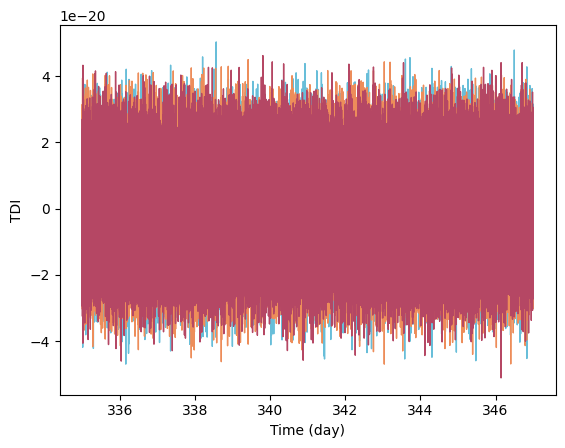

In [7]:
for ich, nch, cch in zip(range(3), channel_names, [BLUE, ORANGE, RED]):
    plt.plot(read_dict["time"][slice_idx]/DAY, AET_dict[nch], label=nch, linewidth=1, color=cch)
plt.xlabel("Time (day)")
plt.ylabel("TDI")

## Load parameters for comparison 

In [8]:
mbhb_idx = np.where((fiducial_parameters["coalescence_time"] >= start_time/DAY + 1.)&(fiducial_parameters["coalescence_time"] <= end_time/DAY - 1.))[0]
N_mbhb = len(mbhb_idx)
for k, v in fiducial_parameters.items():
    fiducial_parameters[k] = v[mbhb_idx]
N_mbhb, fiducial_parameters

(1,
 {'chirp_mass': array([1647214.56120374]),
  'coalescence_phase': array([3.63629981]),
  'coalescence_time': array([343.78579201]),
  'inclination': array([1.02484815]),
  'latitude': array([-0.7932944]),
  'longitude': array([2.40779058]),
  'luminosity_distance': array([118095.40954935]),
  'mass_ratio': array([0.26150338]),
  'psi': array([0.15552461]),
  'spin_1z': array([-0.863535]),
  'spin_2z': array([0.358075])})

## Fourier transform 

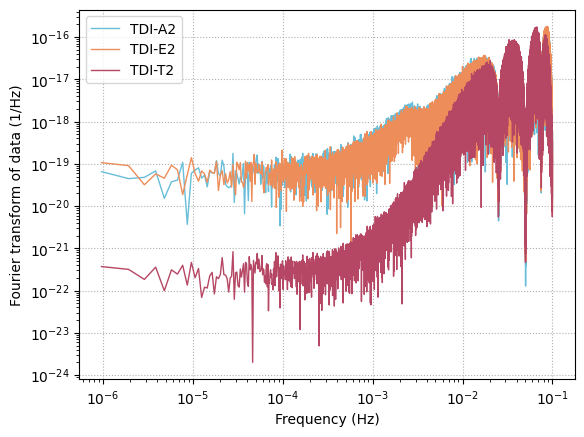

In [9]:
data_channels = [] 
for ich, nch, cch in zip(range(3), channel_names, [BLUE, ORANGE, RED]):
    ff, xf = FFT_window(AET_dict[nch], 1./dt, window_type="tukey", window_args_dict=dict(alpha=0.05))
    plt.loglog(ff, np.abs(xf), linewidth=1, color=cch, label="TDI-"+nch)
    data_channels.append(xf)
data_frequency = ff 
data_channels = np.array(data_channels)

plt.xlabel("Frequency (Hz)")
plt.ylabel("Fourier transform of data (1/Hz)")
plt.legend(loc="upper left")
plt.grid(linestyle=":")

Limit the frequency band to gain speed and avoid singularity

In [10]:
mask = np.ones_like(data_frequency, dtype=bool)
for i in range(1, 40):
    mask_idx = np.where(np.abs(data_frequency - i * 0.025) < 3e-4 * i)[0]
    mask[mask_idx] = False 
mask_idx = np.where(data_frequency>0.01)[0]
mask[mask_idx] = False 
mask_idx = np.where(data_frequency<1e-5)[0]
mask[mask_idx] = False 

data_frequency = xp.array(data_frequency[mask])
delta_f = data_frequency[1] - data_frequency[0]
Tobs = 1. / delta_f
data_channels = xp.array(data_channels[:, mask])

data_frequency.shape, data_channels.shape 

((10358,), (3, 10358))

## Prepare models 

### waveform and response 

In [11]:
mode = "primary" # use primary (2,2) mode for the PhenomD waveform 
use_gpu = True 

# the path of Taiji orbit 
ORBIT_DIR = "/home/ps/workspace/Triangle-Simulator/OrbitData/MicroSateOrbitEclipticTCB"
orbit = Orbit(OrbitDir=ORBIT_DIR)

# initialize  waveform generator 
WFG = BBHxWaveformGenerator(mode=mode, use_gpu=use_gpu)

# initialize response generator 
FDTDI = BBHxFDTDIResponseGenerator(orbit_class=orbit, waveform_generator=WFG, use_gpu=use_gpu)

# response settings 
response_kwargs = dict(
    modes=[(2,2),], 
    tmin=start_time/DAY,
    tmax=end_time/DAY, 
    tc_at_constellation=False, 
    TDIGeneration="2nd", # "1st" or "2nd"
    optimal_combination=True, # True for AET, False for XYZ 
    output_by_mode=False, 
    interpolation=True ,
)

response_kwargs

{'modes': [(2, 2)],
 'tmin': 335.0,
 'tmax': 347.0,
 'tc_at_constellation': False,
 'TDIGeneration': '2nd',
 'optimal_combination': True,
 'output_by_mode': False,
 'interpolation': True}

## Model noise 
Simplifications:
- AE channels are only approximately independent. 
- The noise level of T channel varies significantly with time, thus we do not use T channel in subsequent analysis. 
- During realistic search we usually do not priorly know the PSD of noise 

In [12]:
# noise PSD model 
PSDfunc = TDIPSDs()

# use the median time to calculate armlengths. The PSD of T channel is sensitive to armlength variation, while those of AE are approximately stationary for most frequencies. 
arm_time = (start_time + end_time) / 2. 
arms = dict()
for key in MOSA_labels:
    arms[key] = orbit.LTTfunctions()[key](arm_time)
print("arm lengths:", arms)

# T will not be used 
PSD_channels = xp.array([
    PSDfunc.PSD_A2_unequal(data_frequency.get(), arms), 
    PSDfunc.PSD_E2_unequal(data_frequency.get(), arms), 
    PSDfunc.PSD_T2_unequal(data_frequency.get(), arms)
])

# covariance matrix, this is also an approximate since the channels should be correlated under the unequal-arm regime
CovMat = xp.array([
    [PSD_channels[0], xp.zeros_like(PSD_channels[0]), xp.zeros_like(PSD_channels[0])],
    [xp.zeros_like(PSD_channels[0]), PSD_channels[1], xp.zeros_like(PSD_channels[0])],
    [xp.zeros_like(PSD_channels[0]), xp.zeros_like(PSD_channels[0]), PSD_channels[2]]
]) / 4. / delta_f # (3, 3, Nf)

# inverse of covmatrix
InvCovMat = xp.linalg.inv(xp.transpose(CovMat, (2, 0, 1))) # (Nf, 3, 3)

PSD_channels.shape, InvCovMat.shape 

arm lengths: {'12': array(9.97861075), '13': array(9.91808729), '23': array(9.91899732), '21': array(9.97843802), '31': array(9.91672174), '32': array(9.91778731)}


((3, 10358), (10358, 3, 3))

## Test model with the true parameters 

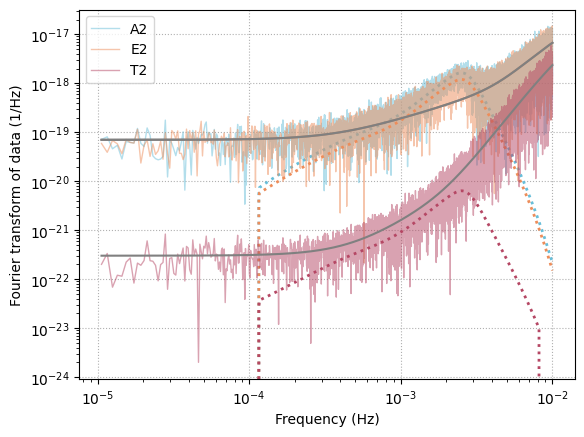

In [13]:
# calculate template 
model_channels = FDTDI.Response(parameters=fiducial_parameters, freqs=data_frequency, **response_kwargs)

for ich, nch, cch in zip(range(3), channel_names, [BLUE, ORANGE, RED]):
    plt.loglog(data_frequency.get(), np.abs(data_channels[ich].get()), label=nch, linewidth=1, color=cch, alpha=0.5)
    plt.loglog(data_frequency.get(), np.abs(model_channels[ich].get()), linewidth=2, linestyle=":", color=cch)
    plt.loglog(data_frequency.get(), np.sqrt((PSD_channels[ich] * Tobs / 2.).get()), color="grey")

plt.legend(loc="upper left")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Fourier transform of data (1/Hz)")
plt.grid(linestyle=":")

## Use A, E channels only 
set $C^{-1}_{T_2 T_2} \equiv 0$ to eliminate the contribution of $T_2$

In [14]:
InvCovMat[:, 2, 2] *= 0. 

## Likelihood

In [15]:
Like = Likelihood(
    response_generator=FDTDI, 
    frequency=data_frequency, 
    data=data_channels, 
    invserse_covariance_matrix=InvCovMat, 
    response_parameters=response_kwargs, 
    use_gpu=use_gpu,
)

number of freuqncies: 10358
min and max frequencies: 1.0609516736512652e-05 0.009999951774923925
response kwargs: {'modes': [(2, 2)], 'tmin': 335.0, 'tmax': 347.0, 'tc_at_constellation': False, 'TDIGeneration': '2nd', 'optimal_combination': True, 'output_by_mode': False, 'interpolation': True}


## Run MCMC Sampling 

the aim is to compare the posteriors of full and heterodyned likelihoods, so we choose ideal priors and starting points. 

In [16]:
from eryn.ensemble import EnsembleSampler
from eryn.state import State
from eryn.prior import ProbDistContainer, uniform_dist
from eryn.utils import TransformContainer
from eryn.moves import GaussianMove, StretchMove, CombineMove
from eryn.utils.utility import groups_from_inds
from eryn.backends import HDFBackend
from eryn.utils import SearchConvergeStopping

from corner import corner

In [17]:
labels = [r"${\rm lg}\mathcal{M}_{c,z}$", r"$q$", r"$\chi_{z,1}$", r"$\chi_{z,2}$", r"$t_c$", r"$\varphi_c$", r"${\rm lg} D_L$", r"$\cos \iota$", r"$\lambda$", r"$\sin \beta$", r"$\psi$"]

truths = np.array(ParamDict2ParamArr(fiducial_parameters))

truths = truths[:, 0]

truths

array([ 6.21675017e+00,  2.61503375e-01, -8.63535000e-01,  3.58075000e-01,
        3.43785792e+02,  3.63629981e+00,  5.07223302e+00,  5.19228673e-01,
        2.40779058e+00, -7.12668158e-01,  1.55524611e-01])

In [18]:
# set hyper parameters
ndim = 11 # dimension of paramters 
nwalkers = 400 # number of random walkers, limited by the vRAM of my 4080S, use fewer (e.g. 100) to speed up and more (e.g. 400) to get more smooth posterior 
ntemps = 10 # number of temperatures used in parallel tempering 
temps = np.array(list(np.power(2., np.arange(ntemps - 1))) + [np.infty]) 
betas = 1. / temps 
tempering_kwargs=dict(betas=betas)

mcmc_moves = StretchMove(a=2) # mcmc move 

stop = None 

# set priors 
lim_lgMc = [truths[0] - 0.1, truths[0] + 0.1] # we have demonstrated that this is practical 
lim_q = [0.1, 0.99]
lim_chiz1 = [-0.99, 0.99]
lim_chiz2 = [-0.99, 0.99]
lim_tc = [truths[4] - 1e-2, truths[4] + 1e-2] # we have demonstrated that this is practical 
lim_phic = [0, TWOPI]
lim_lgD = [truths[6] - 0.5, truths[6] + 0.5] # we have demonstrated that this is practical 
lim_cosinc = [-1, 1]
lim_lam = [0, TWOPI]
lim_sinbeta = [-1, 1]
lim_psi = [0, PI]

lims = np.array([lim_lgMc, lim_q, lim_chiz1, lim_chiz2, lim_tc, lim_phic, lim_lgD, lim_cosinc, lim_lam, lim_sinbeta, lim_psi])
lower_lims = lims[:, 0]
upper_lims = lims[:, 1]

priors_in = {i: uniform_dist(lims[i][0], lims[i][1]) for i in range(ndim)}
priors = ProbDistContainer(priors_in)
priors.use_cupy = False

# set starting range 
start_lims = lims 
start_priors_in = {i: uniform_dist(start_lims[i][0], start_lims[i][1]) for i in range(ndim)}
start_priors = ProbDistContainer(start_priors_in)
start_priors.use_cupy = False

lims, start_lims

(array([[ 6.11675017e+00,  6.31675017e+00],
        [ 1.00000000e-01,  9.90000000e-01],
        [-9.90000000e-01,  9.90000000e-01],
        [-9.90000000e-01,  9.90000000e-01],
        [ 3.43775792e+02,  3.43795792e+02],
        [ 0.00000000e+00,  6.28318531e+00],
        [ 4.57223302e+00,  5.57223302e+00],
        [-1.00000000e+00,  1.00000000e+00],
        [ 0.00000000e+00,  6.28318531e+00],
        [-1.00000000e+00,  1.00000000e+00],
        [ 0.00000000e+00,  3.14159265e+00]]),
 array([[ 6.11675017e+00,  6.31675017e+00],
        [ 1.00000000e-01,  9.90000000e-01],
        [-9.90000000e-01,  9.90000000e-01],
        [-9.90000000e-01,  9.90000000e-01],
        [ 3.43775792e+02,  3.43795792e+02],
        [ 0.00000000e+00,  6.28318531e+00],
        [ 4.57223302e+00,  5.57223302e+00],
        [-1.00000000e+00,  1.00000000e+00],
        [ 0.00000000e+00,  6.28318531e+00],
        [-1.00000000e+00,  1.00000000e+00],
        [ 0.00000000e+00,  3.14159265e+00]]))

In [19]:
def eryn_like(params): 
    """params: numpy array of shape (Nevents, Nparams)"""
    return Like.full_log_like_vectorized(np.transpose(params))

In [20]:

ensemble = EnsembleSampler(
    nwalkers,
    ndim,
    eryn_like, 
    priors,
    args=[],
    tempering_kwargs=tempering_kwargs,
    stopping_fn=stop,
    stopping_iterations=10,
    moves=mcmc_moves,
    vectorize=True,
)

In [21]:
# randomize starting positions throughout prior
coords = start_priors.rvs(size=(ntemps, nwalkers,))
print(coords.shape)

thin_by = 100 
burn = 0
nsteps = int(100000 / thin_by) # should be more than enough 

ensemble.stopping_fn = None

out = ensemble.run_mcmc(coords, nsteps, burn=burn, progress=True, thin_by=thin_by)

(10, 400, 11)


 15%|█▍        | 14584/100000 [1:42:29<9:52:31,  2.40it/s] Traceback (most recent call last):
  File "/home/ps/miniconda3/envs/taiji_data/lib/python3.9/site-packages/eryn/ensemble.py", line 1584, in __call__
    out = self.f(*args_in, **kwargs_in)
  File "/tmp/ipykernel_63369/3181406468.py", line 3, in eryn_like
    return Like.full_log_like_vectorized(np.transpose(params))
  File "/home/ps/.local/lib/python3.9/site-packages/Triangle_BBH-0.1.0-py3.9.egg/Triangle_BBH/Utils.py", line 174, in full_log_like_vectorized
    return np.real(-0.5 * loglikes.get())
KeyboardInterrupt
 15%|█▍        | 14584/100000 [1:42:29<10:00:19,  2.37it/s]

eryn: Exception while calling your likelihood function:
  args added: [array([[ 6.31331414,  0.18785924, -0.69555252, ...,  0.20575006,
         0.90783897,  1.83577468],
       [ 6.2517018 ,  0.12527069,  0.01096954, ...,  3.08284505,
        -0.21346287,  0.43562639],
       [ 6.23592553,  0.1568987 , -0.82866146, ...,  1.44983601,
         0.50321485,  1.84629536],
       ...,
       [ 6.18435131,  0.6484803 ,  0.35969473, ...,  4.69823251,
        -0.02458073,  1.94907426],
       [ 6.18316044,  0.30160191,  0.18328251, ...,  4.13713139,
         0.61602461,  1.39603198],
       [ 6.15276203,  0.90221648, -0.39021659, ...,  5.70027476,
        -0.22611621,  1.31081226]])]
  args: []
  kwargs added: {}
  kwargs: {}
  exception:


KeyboardInterrupt: 

In [23]:
# resume run after the run is stopped 
thin_by =100
burn = 0
nsteps = int(150000 / thin_by) # this should be far more than enough 

out = ensemble.run_mcmc(ensemble.get_last_sample(), nsteps, burn=burn, progress=True, thin_by=thin_by)

  8%|▊         | 11517/150000 [1:20:20<16:09:06,  2.38it/s]Traceback (most recent call last):
  File "/home/ps/miniconda3/envs/taiji_data/lib/python3.9/site-packages/eryn/ensemble.py", line 1584, in __call__
    out = self.f(*args_in, **kwargs_in)
  File "/tmp/ipykernel_63369/3181406468.py", line 3, in eryn_like
    return Like.full_log_like_vectorized(np.transpose(params))
  File "/home/ps/.local/lib/python3.9/site-packages/Triangle_BBH-0.1.0-py3.9.egg/Triangle_BBH/Utils.py", line 163, in full_log_like_vectorized
    template = self.response_generator.Response(
  File "/home/ps/.local/lib/python3.9/site-packages/Triangle_BBH-0.1.0-py3.9.egg/Triangle_BBH/Response.py", line 1148, in Response
    results[self.xp.abs(results)<1e-23]=0.
  File "cupy/_core/core.pyx", line 1641, in cupy._core.core._ndarray_base.__setitem__
  File "cupy/_core/_routines_indexing.pyx", line 51, in cupy._core._routines_indexing._ndarray_setitem
  File "cupy/_core/_routines_indexing.pyx", line 1003, in cupy._core

eryn: Exception while calling your likelihood function:
  args added: [array([[ 6.16044669,  0.12422267, -0.83297694, ...,  2.00370059,
         0.28028362,  0.684138  ],
       [ 6.18869108,  0.14111356, -0.98311321, ...,  5.58341433,
        -0.3444236 ,  2.96328711],
       [ 6.25536408,  0.14407341, -0.39204821, ...,  3.93723132,
        -0.69979272,  2.57014602],
       ...,
       [ 6.18054947,  0.56083893,  0.12311441, ...,  0.35611143,
        -0.109281  ,  0.70971793],
       [ 6.22939431,  0.61549745, -0.76166226, ...,  3.32280192,
         0.05198704,  2.73524027],
       [ 6.24709788,  0.30094364, -0.57544479, ...,  2.83763534,
         0.69864672,  2.45510476]])]
  args: []
  kwargs added: {}
  kwargs: {}
  exception:


KeyboardInterrupt: 

## Show moves 

<Figure size 640x480 with 0 Axes>

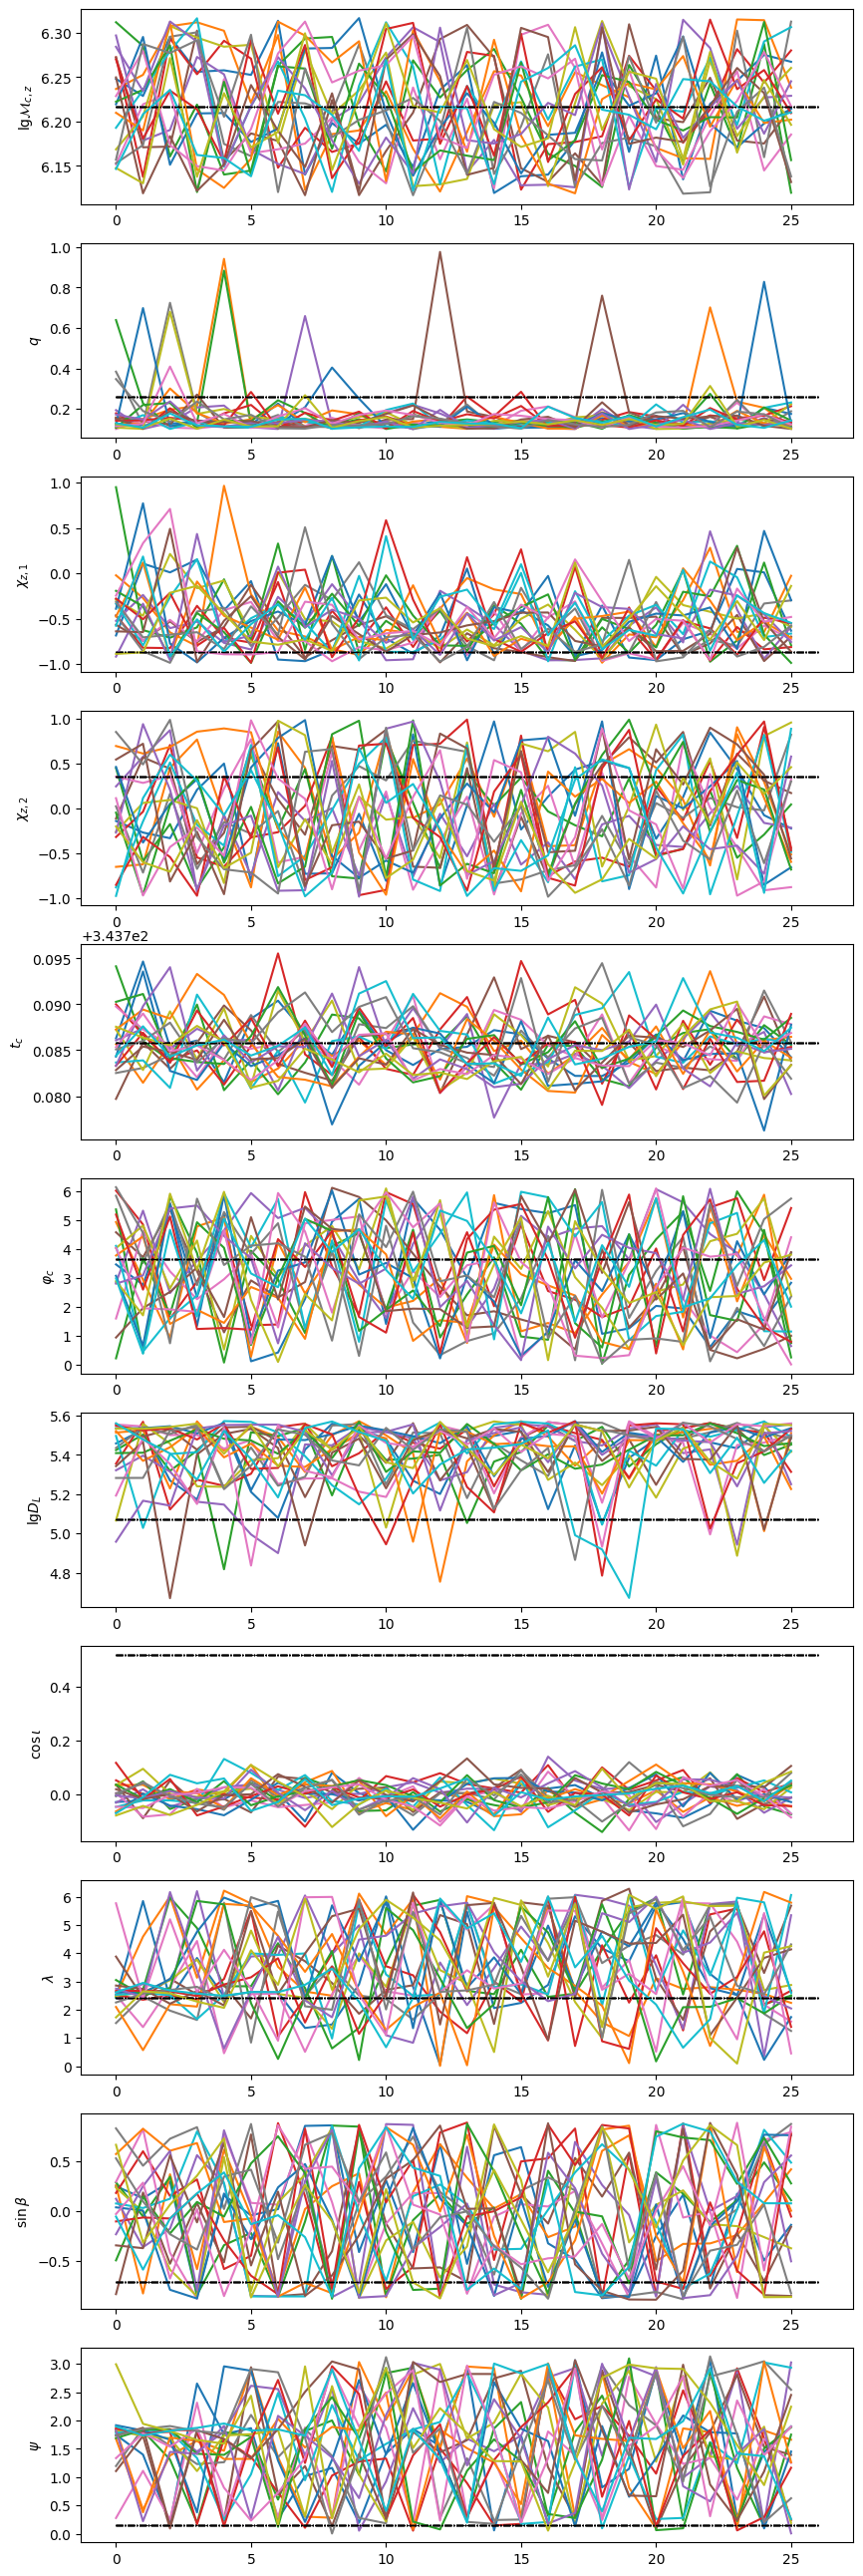

In [24]:
thin = 10
burnin = 0
len_chain = len(ensemble.get_chain(thin=thin, discard=burnin)['model_0'][:, 0, 0, :, 0])

plt.figure()
fig, ax = plt.subplots(ndim, 1)
fig.set_size_inches(10, 3*ndim)
for i in range(ndim):     
    for walk in range(20): # plot 20 walkers 
        ax[i].plot(ensemble.get_chain(thin=thin, discard=burnin)['model_0'][:, 0, walk, 0, i])
        ax[i].hlines(truths[i], 0, len_chain, color='k', linestyle='-.', linewidth=0.8)
    ax[i].set_ylabel(labels[i])

## Corner plot
$t_c$ and $\varphi_c$ are not perfectly matched, the reason of which is explaned in Example 3.

sample shape: (6400, 11)


<Figure size 640x480 with 0 Axes>

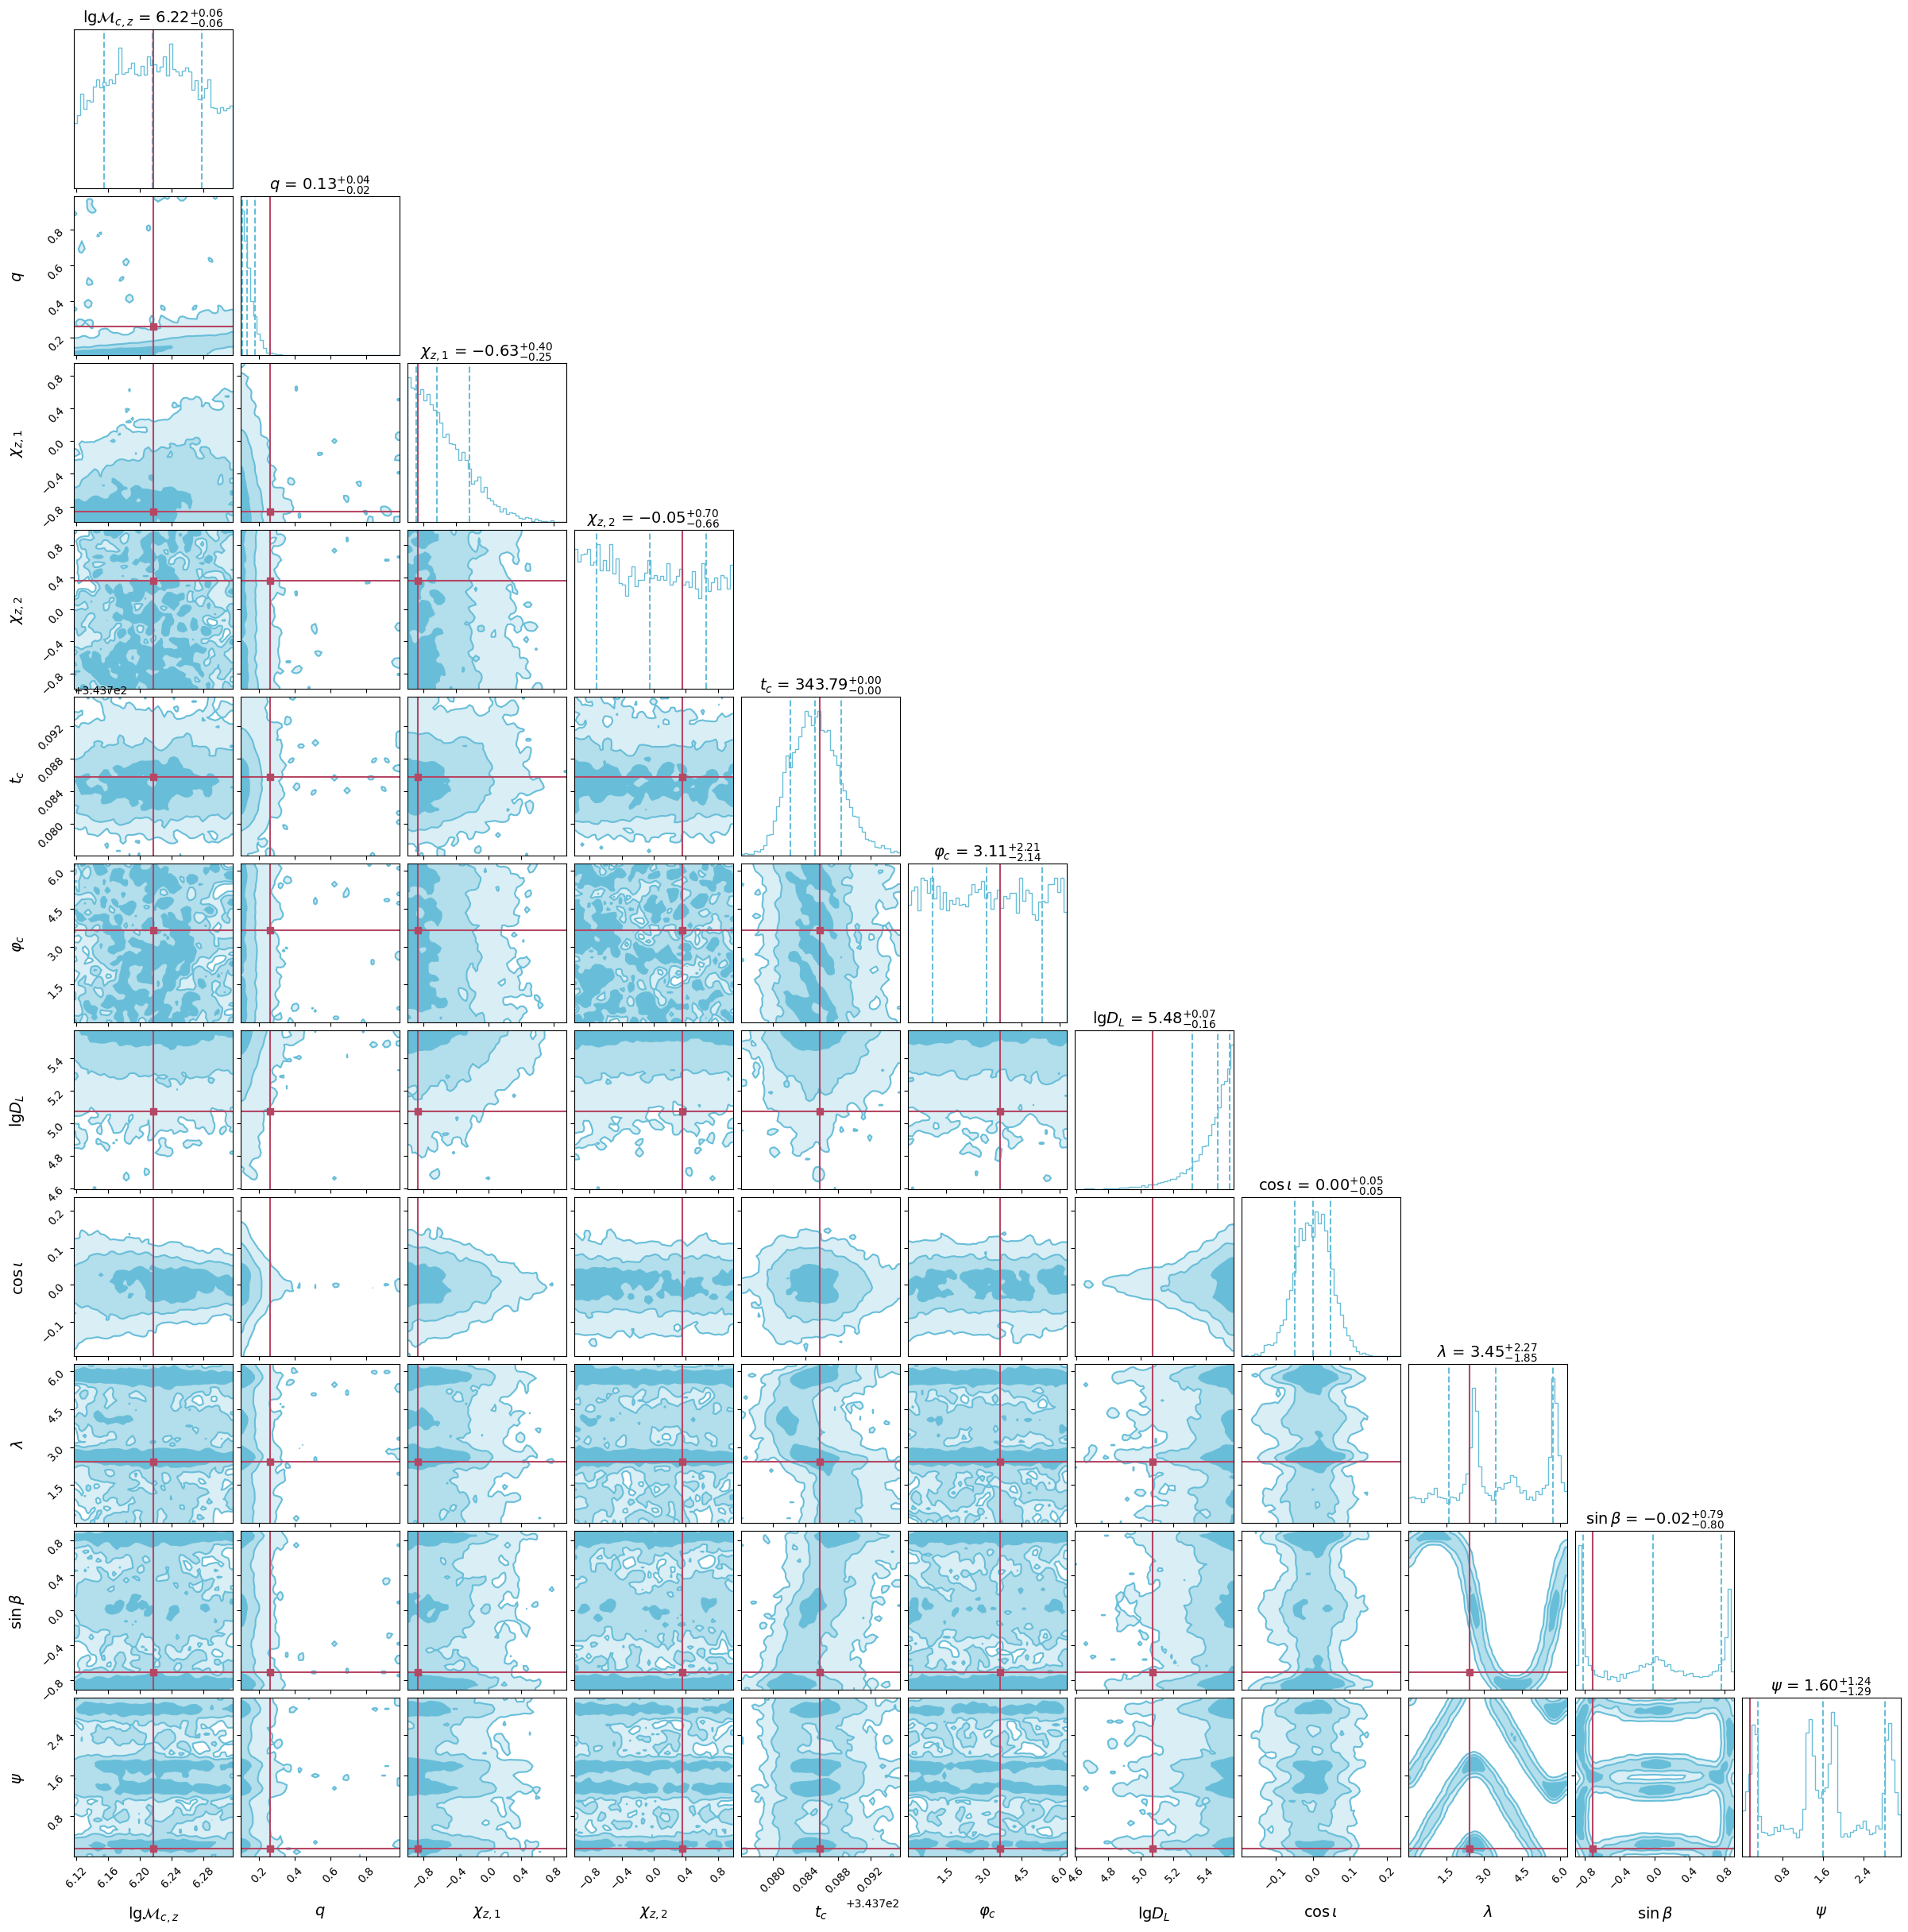

In [25]:
burnin=100
thin = 10

samp = ensemble.get_chain(discard=burnin, thin=thin)['model_0'][:, 0, :, :, :].reshape(-1, ndim)
print("sample shape:", samp.shape)

# samp_idx = np.where(samp[:, 7]>0)[0]
# samp = samp[samp_idx]

plt.figure()
corner(
    samp, bins=50, color=BLUE, 
    labels=labels, label_kwargs={'fontsize': 14}, 
    # range=lims,
    truths=truths, truth_color=RED, 
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True, title_kwargs={'fontsize':14},
    levels = (1. - np.exp(-1.**2/2), 1. - np.exp(-2.**2/2), 1. - np.exp(-3.**2/2)),
    smooth=0.9, # default for bilby: smooth = 0.9, bins = 50 
    plot_density=True, # whether to show the density of samples with colors 
    plot_datapoints=False, # whether to plot individual data points 
    fill_contours=True, # whether to fill the corners 
    );
# plt.savefig("/home/ps/workspace/Triangle-BBH/Examples/Verification_corner.jpg")
# np.save("/home/ps/workspace/Triangle-BBH/Examples/chain_verification.npy", samp)